In [1]:
from rl4greencrab.envs.simple_env import SimpleEnv
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab import evaluate_agent, multiConstAction, simulator
import pandas as pd
import numpy as np
from rl4greencrab import plot_agent
import ray

INFO: Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO: Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO: NumExpr defaulting to 16 threads.
/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [2]:
from rl4greencrab import greenCrabMonthEnvSimple, greenCrabMonthEnvSimpleNormalized, greenCrabMonthEnvSize, greenCrabMonthEnvSizeNormalized

In [3]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0
    # "curriculum": True
}

In [4]:
# normalized constant action
def normalized_action(act, max_act):
    max_action = max_act
    constant_act = np.array(act)
    return constant_act * 2 / max_action - 1 

In [5]:
act = np.array([100,1,1])
env = greenCrabMonthEnvSimple(config)

In [6]:
act = np.array([-0.93333333, -0.99933333, -0.99933333])
env = greenCrabMonthEnvSimpleNormalized(config)

In [7]:
act = np.array([100,1,1])
env = greenCrabMonthEnvSize(config)

In [8]:
act = np.array([0,0,1000])
env = greenCrabMonthEnvSizeNormalized(config)

In [5]:
evalEnv = greenCrabMonthEnvSizeNormalized(config)

In [4]:
td3Agent = TD3.load(f"../saved_agents/TD3-gcmonthenvsizenorm-1", device="cpu")
ppoAgent = PPO.load(f"../saved_agents/PPO-gcmonthenvsizenorm-1", device="cpu")
tqcAgent = TQC.load(f"../saved_agents/TQC-gcmonthenvsizenorm-1", device="cpu")
recurrentPPOAgent = RecurrentPPO.load("RecurrentPPO_gcmonthenvsizenorm_256_1_{'pi': [256, 256], 'vf': [256, 256]}_False", device="cpu")

In [7]:
import ray
N_EPS = 30
# ray.init()
ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
td3_rew= evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)

In [13]:
ray.shutdown()

In [8]:
ppo_rew, td3_rew, tqc_rew, reppo_rew

(-8.897932466996966,
 -21.300101426488233,
 -4.484074109534046,
 -4.028808858960044)

In [7]:
evalEnv = greenCrabMonthEnvSizeNormalized(config)
ppo_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name='tqc_agent_size', 
                            env=evalEnv, 
                            agent=tqcAgent, 
                            save_dir='.')
ppo_plot_agent.gen_env_sim_df(rep=10)

,t,obs0,obs1,act0,act1,act2,rew,rep,crab_pop,nonlocal_crab
0,0,-1.0,-1.0,-0.938868,-0.671192,-0.908549,0.000000,0,"[0.002692550773573064, 0.044636597754072825, 0...",[]
1,1,-1.0,-1.0,-0.846294,-0.885154,-0.936832,-0.034022,0,"[0.0002912241904211013, 0.007535743334319388, ...",[]
2,2,-1.0,-1.0,-0.960321,-0.952204,-0.926445,-0.057511,0,"[1.6942150784311086e-12, 3.5141544644239134e-0...",[]
3,3,-1.0,-1.0,-0.964028,0.154481,-0.964028,-0.075819,0,"[8.969080409732206e-19, 7.527571945968349e-12,...",[]
4,4,-1.0,-1.0,-0.901544,-0.470620,-0.942124,-0.130711,0,"[1.4105461802363523e-26, 4.919241146934665e-18...",[]
...,...,...,...,...,...,...,...,...,...,...
995,95,-1.0,-1.0,-0.879302,-0.700546,-0.947210,-4.312065,9,"[0.016566836571195384, 2.967799097984831, 54.7...","[8585.05217193937, 7209.389694958607, 6149.983..."
996,96,-1.0,-1.0,-0.936803,-0.778861,-0.940103,-4.340010,9,"[0.001446626794528315, 0.29086488341206285, 9....","[8585.05217193937, 7209.389694958607, 6149.983..."
997,97,-1.0,-1.0,-0.964028,-0.672793,-0.908670,-4.364104,9,"[1.7538096261257128e-06, 0.009541686725389758,...","[8585.05217193937, 7209.389694958607, 6149.983..."
998,98,-1.0,-1.0,-0.913525,-0.858613,-0.930091,-4.397475,9,"[1.9488712560462e-07, 0.001064209320291838, 0....","[8585.05217193937, 7209.389694958607, 6149.983..."


Saved ./tqc_agent_size/actions_over_time.png


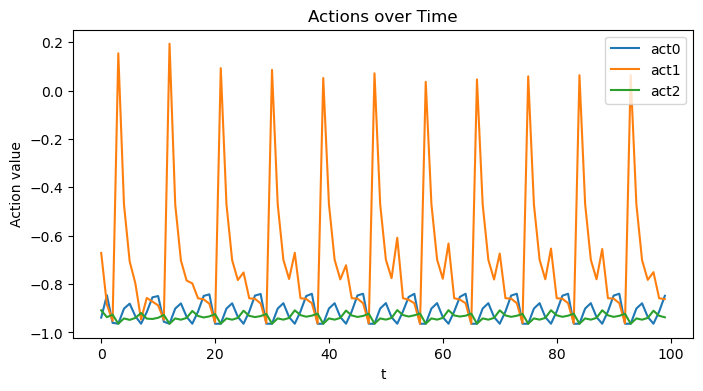

Saved ./tqc_agent_size/obs0_over_time.png


<Figure size 800x400 with 0 Axes>

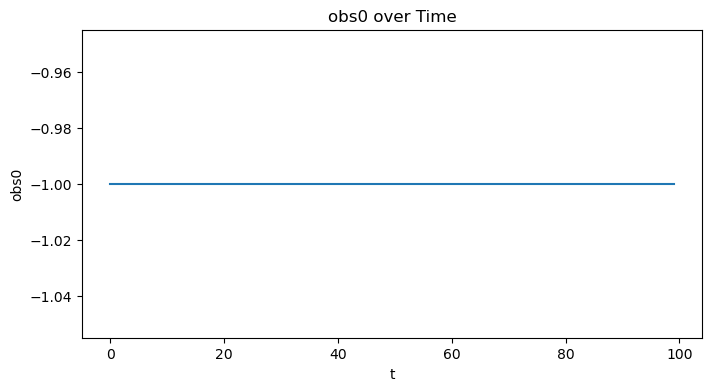

In [8]:
ppo_plot_agent.agent_action_overtime_plots()
ppo_plot_agent.agent_ob_overtime_plots(obs_name='obs0')

In [11]:
evalEnv = greenCrabMonthEnvSizeNormalized(config)
tqc_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name='tqc_agent_size', 
                            env=evalEnv, 
                            agent=tqcAgent, 
                            save_dir='.')
df = tqc_plot_agent.gen_env_sim_df(rep=10)

Saved ./tqc_agent_size/actions_over_time.png


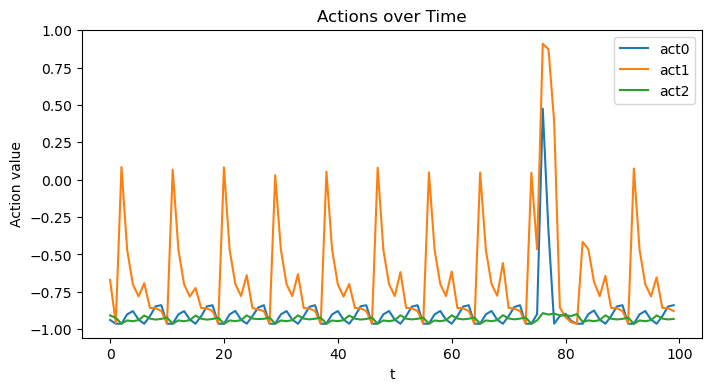

Saved ./tqc_agent_size/obs0_over_time.png


<Figure size 800x400 with 0 Axes>

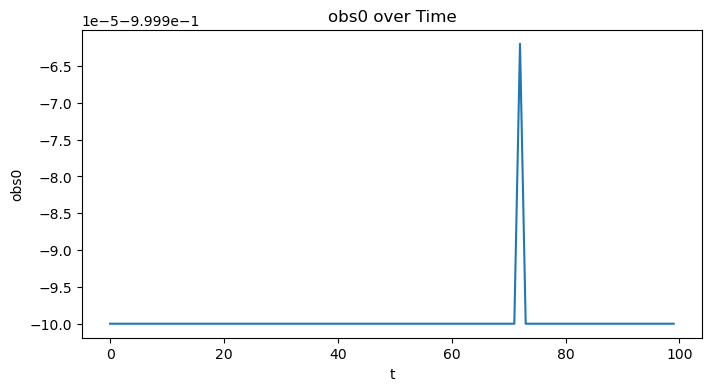

In [19]:
tqc_plot_agent.agent_action_overtime_plots()
tqc_plot_agent.agent_ob_overtime_plots(obs_name='obs0')

In [6]:
evalEnv = greenCrabMonthEnvSizeNormalized(config)
rppo_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name='rppo_agent_size', 
                            env=evalEnv, 
                            agent=recurrentPPOAgent, 
                            save_dir='.')
df = rppo_plot_agent.gen_env_sim_df(rep=10)

Saved ./rppo_agent_size/actions_over_time.png


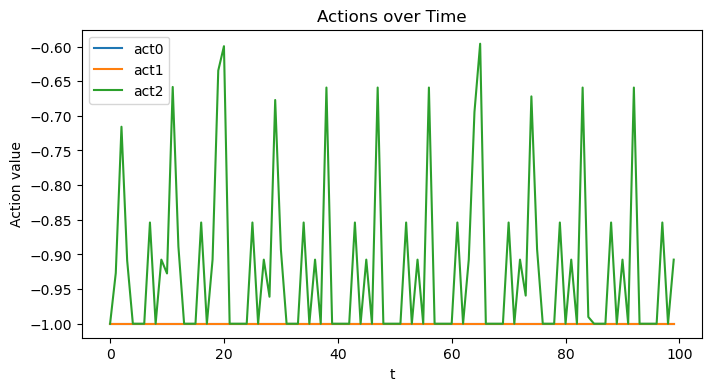

Saved ./rppo_agent_size/obs0_over_time.png


<Figure size 800x400 with 0 Axes>

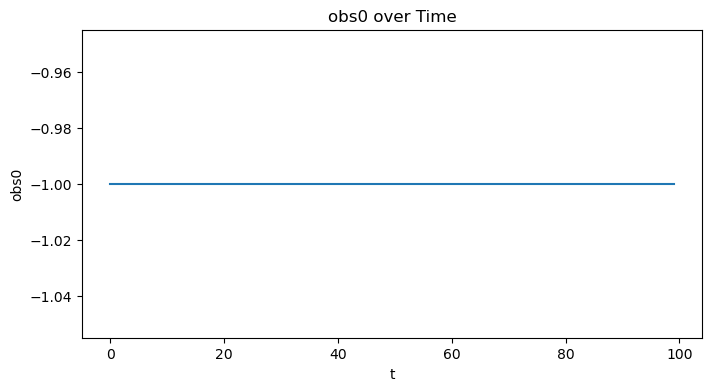

In [7]:
rppo_plot_agent.agent_action_overtime_plots()
rppo_plot_agent.agent_ob_overtime_plots(obs_name='obs0')

In [25]:
td3AgentSimple = TD3.load(f"../saved_agents/TD3-gcmonthenvsimplenorm-1", device="cpu")
ppoAgentSimple = PPO.load(f"../saved_agents/PPO-gcmonthenvsimplenorm-1", device="cpu")
tqcAgentSimple = TQC.load(f"../saved_agents/TQC-gcmonthenvsimplenorm-1", device="cpu")

In [26]:
evalEnv = greenCrabMonthEnvSimpleNormalized(config)

In [27]:
import ray
N_EPS = 30
ray.init()
ppo_rew = evaluate_agent(agent=ppoAgentSimple, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
td3_rew= evaluate_agent(agent=td3AgentSimple, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgentSimple, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
# reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

2025-08-07 18:24:14,550	INFO worker.py:1917 -- Started a local Ray instance.


True
{'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 21677465600.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 9290342400.0, 'GPU': 2.0, 'node:10.42.0.111': 1.0}


(simulator pid=15538) /opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
(simulator pid=15538)   gym.logger.warn(


True
{'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 21677465600.0, 'accelerator_type:RTX': 1.0, 'node:10.42.0.111': 1.0, 'GPU': 2.0, 'object_store_memory': 9290342400.0}
True
{'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 21677465600.0, 'node:10.42.0.111': 1.0, 'accelerator_type:RTX': 1.0, 'GPU': 2.0, 'object_store_memory': 9290342400.0}


In [28]:
ppo_rew, td3_rew, tqc_rew

(-6.24876241607001, -16.405026624726627, -9.353070690425149)

In [31]:
evalEnv = greenCrabMonthEnvSimpleNormalized(config)
ppo_plot_agent_simple = plot_agent(env_sim_df=None, 
                            agent_name='ppo_agent_simple', 
                            env=evalEnv, 
                            agent=ppoAgentSimple, 
                            save_dir='.')
ppo_plot_agent_simple.gen_env_sim_df(rep=10)

,t,obs0,act0,act1,act2,rew,rep,crab_pop
0,0,-1.000000,0.046029,-0.903226,-1.0,0.000000,0,"[0.0019350980918902924, 0.03207969037767041, 0..."
1,1,-0.995135,0.048320,-0.888419,-1.0,-0.046293,0,"[57.52501540146948, 876.4365501598681, 3482.16..."
2,2,-0.997230,0.047329,-0.894819,-1.0,-0.093415,0,"[6.096178710240509, 140.68412485126166, 1065.5..."
3,3,-0.995558,0.048119,-0.889713,-1.0,-0.140521,0,"[0.6744474903270739, 20.820464412668272, 240.2..."
4,4,-0.990976,0.050302,-0.875605,-1.0,-0.188202,0,"[0.012970535247009325, 2.350775568841341, 46.7..."
...,...,...,...,...,...,...,...,...
995,95,-0.982386,0.054461,-0.848713,-1.0,-6.313810,9,"[0.0014468216664059543, 0.2919259297449267, 9...."
996,96,-0.979830,0.055715,-0.840607,-1.0,-6.363114,9,"[1.7538147087664636e-06, 0.009542740934091016,..."
997,97,-0.982520,0.054396,-0.849136,-1.0,-6.412428,9,"[1.9488881981700772e-07, 0.001064560713155461,..."
998,98,-0.987665,0.051895,-0.865306,-1.0,-6.461119,9,"[7547.206781447065, 3606.8148597998, 0.8307067..."


Saved ./ppo_agent_simple/actions_over_time.png


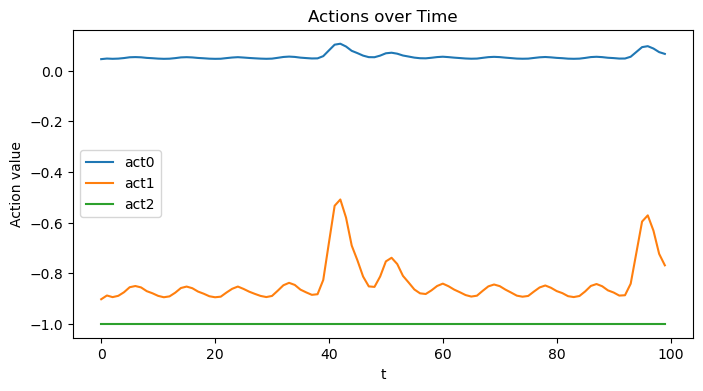

Saved ./ppo_agent_simple/obs0_over_time.png


<Figure size 800x400 with 0 Axes>

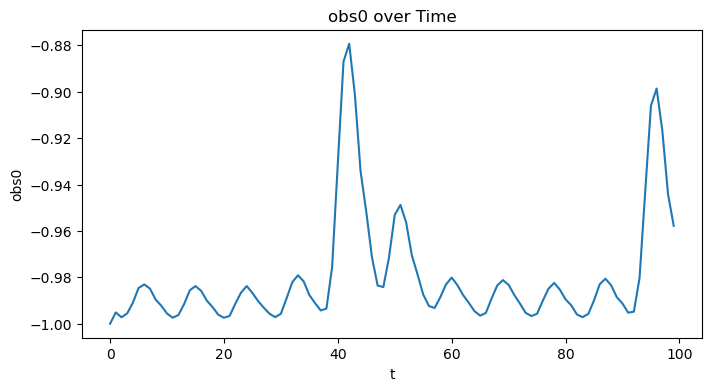

In [32]:
ppo_plot_agent_simple.agent_action_overtime_plots()
ppo_plot_agent_simple.agent_ob_overtime_plots(obs_name='obs0')